# DBT Allocation EDA and Prediction Preparation

**Objective:**  
Analyze historical Direct Benefit Transfer (DBT) data at the district/state level to extract insights and prepare features for future prediction of how much DBT each region should receive.

## 📄 Dataset Summary

This dataset contains **district-level financial year-wise data** on **Direct Benefit Transfers (DBT)** across Indian states. It includes both the **number of transactions** and the **total amount transferred**, and serves as a foundation for analyzing trends, regional disparities, and building predictive models for future DBT allocation.

### 🧮 Data Granularity
- **Geographic granularity:** District-level (`district_name`, `state_name`)
- **Temporal granularity:** Financial year (`fy`) — e.g., "2020-21"

Each row represents DBT data for **one district in one financial year**.

---

### 🧾 Column Descriptions

| Column Name | Description |
|-------------|-------------|
| `id` | Unique identifier for each record (primary key) |
| `fy` | Financial year representing the time period |
| `state_name` | Full name of the state |
| `state_code` | Short code or abbreviation for the state |
| `district_name` | Full name of the district |
| `district_code` | Unique numeric code for the district |
| `total_dbt_transfer` | Total monetary value of DBT transferred in ₹ for that district and year |
| `no_of_dbt_transactions` | Total number of DBT transactions made in that district and year |

---

This structure allows for detailed **temporal**, **regional**, and **quantitative** analysis — making it ideal for both **exploratory insights** and **machine learning-based predictions**.


# Dataset Summary and Initial Inspection

This code imports the required Python libraries, loads the DBT district-wise dataset, and performs an initial inspection to understand its structure and content.  

**Key actions performed:**
- Import libraries for data handling (`pandas`, `numpy`) and visualization (`matplotlib`, `seaborn`).
- Load the CSV dataset into a pandas DataFrame.
- Display the first few rows to preview the data.
- Show dataset information (row/column count, data types, and non-null values) to identify potential missing values or datatype issues.

This step gives a quick overview of the dataset and ensures it is correctly loaded before further cleaning or analysis.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import json
import requests

# Read the CSV file
df = pd.read_csv('dbt-district-wise.csv')

# Display the first few rows and basic information
print("\nDataset Info:")
print(df.info())
print("Dataset Description:")
df.head()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3825 entries, 0 to 3824
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3825 non-null   int64  
 1   fy                      3825 non-null   object 
 2   state_name              3825 non-null   object 
 3   state_code              3825 non-null   int64  
 4   district_name           3825 non-null   object 
 5   district_code           3825 non-null   int64  
 6   total_dbt_transfer      3704 non-null   float64
 7   no_of_dbt_transactions  3704 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 239.2+ KB
None
Dataset Description:


,id,fy,state_name,state_code,district_name,district_code,total_dbt_transfer,no_of_dbt_transactions
0,0,2019-2020,Jammu And Kashmir,1,Anantnag,1,203800000.0,720115.0
1,1,2019-2020,Jammu And Kashmir,1,Budgam,2,54600000.0,204443.0
2,2,2019-2020,Jammu And Kashmir,1,Baramulla,3,246800000.0,911993.0
3,3,2019-2020,Jammu And Kashmir,1,Doda,4,53800000.0,243799.0
4,4,2019-2020,Jammu And Kashmir,1,Jammu,5,442000000.0,2277901.0


# Data Cleaning

This section focuses on preparing the DBT district-wise dataset for accurate analysis and future predictive modeling.  
The goal is to ensure that the dataset is clean, consistent, and ready for Exploratory Data Analysis (EDA).


### Step 1: Clean Column Names

**Purpose:**  
We standardize all column names to make them consistent and easier to use in Python.  
This avoids issues when referencing columns that contain spaces or mixed cases.

**Method used:**  
- **`str.lower()`** → Converts all column names to lowercase.  
- **`str.replace(' ', '_')`** → Replaces spaces with underscores for Python-friendly naming.  

In [3]:
# Clean column names: convert to lowercase and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Display the new column names
print("Updated column names:")
print(df.columns.tolist())

Updated column names:
['id', 'fy', 'state_name', 'state_code', 'district_name', 'district_code', 'total_dbt_transfer', 'no_of_dbt_transactions']


### Step 2: Drop Irrelevant Columns

**Purpose:**  
We remove the columns `district_code` and `state_code` from the dataset because:  
- They are **identifiers** and do not provide meaningful information for analysis or prediction.  
- Retaining only essential columns simplifies the dataset for EDA and future ML modeling.

**Method used:**  
- **`df.drop(columns=[...], inplace=True)`** → Permanently drops the specified columns from the DataFrame.

In [4]:
df.drop(columns = ['district_code', 'state_code'], inplace=True)

### Step 3: Handle Missing Values

**Purpose:**  
1. We first check the number of missing values in each column to identify incomplete data.  
2. For the numeric columns `total_dbt_transfer` and `no_of_dbt_transactions`, missing values are filled using the **median value of their respective district**.  
   - This ensures that imputation respects local district trends rather than using a global median.  
3. After imputation, we verify that no missing values remain in the dataset.

**Methods used:**  
- **`df.isnull().sum()`** → Counts missing values in each column.  
- **`groupby('district_name').transform(lambda x: x.fillna(x.median()))`** →  
  Fills NaN values with the median value computed **per district**.  
- **`fillna()`** → Replaces missing entries with the computed median.

In [5]:
# Check for missing values
print("Missing values count in each column:")
print(df.isnull().sum())

# Handle missing values by filling with median values grouped by district
for column in ['total_dbt_transfer', 'no_of_dbt_transactions']:
    df[column] = df.groupby('district_name')[column].transform(lambda x: x.fillna(x.median()))

# Check if there are any remaining missing values
print("Remaining missing values after handling:")
print(df.isnull().sum())

Missing values count in each column:
id                          0
fy                          0
state_name                  0
district_name               0
total_dbt_transfer        121
no_of_dbt_transactions    121
dtype: int64
Remaining missing values after handling:
id                        0
fy                        0
state_name                0
district_name             0
total_dbt_transfer        0
no_of_dbt_transactions    0
dtype: int64


### Step 4: Normalize Monetary Values

This cell standardizes the `total_dbt_transfer` field by stripping currency symbols and thousands separators so it becomes a pure numeric value suitable for computation.

**Purpose:**  
Ensure that the transfer amounts are stored as floats, removing any formatting like `₹` or commas that would prevent numeric operations.

**Technique:**  
- A helper function `clean_monetary_value` is defined to:
  - Detect string entries,
  - Remove the rupee symbol and commas,
  - Convert the cleaned string to `float`.
- The function is applied to the `total_dbt_transfer` column using `.apply()`.  
- A sample of the cleaned values is printed to verify the transformation.


In [6]:
# Convert monetary column (remove ₹ and commas if present)
def clean_monetary_value(x):
    if isinstance(x, str):
        return float(str(x).replace('₹', '').replace(',', ''))
    return x

# Clean total_dbt_transfer column
df['total_dbt_transfer'] = df['total_dbt_transfer'].apply(clean_monetary_value)

print("Sample of cleaned monetary values:")
print(df[['total_dbt_transfer']].head())

Sample of cleaned monetary values:
   total_dbt_transfer
0         203800000.0
1          54600000.0
2         246800000.0
3          53800000.0
4         442000000.0


### Step 5: Finalize Numeric Types

**Purpose:**  
Ensure that the key numerical columns are in integer form for consistency and downstream modeling, since transaction counts and total transfer amounts should be whole numbers.

**Approach:**  
- Round any floating values to the nearest integer.  
- Cast both `no_of_dbt_transactions` and `total_dbt_transfer` to `int64` type.  
- Display updated dtypes and a sample to confirm the conversion.


In [7]:
# Convert no_of_dbt_transactions to integer type (rounding any decimal values)
df['no_of_dbt_transactions'] = df['no_of_dbt_transactions'].round().astype('int64')
df['total_dbt_transfer'] = df['total_dbt_transfer'].round().astype('int64')

print("Updated datatypes after converting transactions to integer:")
print(df.dtypes)

# Show sample of the data to verify
print("\nSample data with updated types:")
print(df[['total_dbt_transfer', 'no_of_dbt_transactions']].head())

Updated datatypes after converting transactions to integer:
id                         int64
fy                        object
state_name                object
district_name             object
total_dbt_transfer         int64
no_of_dbt_transactions     int64
dtype: object

Sample data with updated types:
   total_dbt_transfer  no_of_dbt_transactions
0           203800000                  720115
1            54600000                  204443
2           246800000                  911993
3            53800000                  243799
4           442000000                 2277901


### Step 6: Detect and Remove Duplicates

**Purpose:**  
Eliminate any repeated records to prevent biased analysis or double-counting in downstream modeling.

**Approach:**  
- Count duplicate rows with `.duplicated().sum()`.  
- Remove duplicates using `.drop_duplicates()`.  
- Compare dataset shape before and after to confirm how many rows were dropped.  
- Update the main DataFrame with the cleaned version.


In [8]:
# Check for duplicate rows
print("Number of duplicate rows:", df.duplicated().sum())

# Remove duplicate rows if any exist
df_clean = df.drop_duplicates()

# Print the shape before and after removing duplicates
print("\nDataset shape:")
print(f"Before removing duplicates: {df.shape}")
print(f"After removing duplicates: {df_clean.shape}")

# Reassign to original variable
df = df_clean

Number of duplicate rows: 0

Dataset shape:
Before removing duplicates: (3825, 6)
After removing duplicates: (3825, 6)


### Step 7: Extract Start and End Years from Fiscal Year

**Objective:**  
Derive explicit numeric `start_year` and `end_year` from the compact `fy` string (e.g., "20-21" or "2020-21") to enable temporal analysis and trend modeling.

**Implementation:**  
- A helper function `split_fy` parses the `fy` string, normalizes two-digit or four-digit segments, and returns separate start and end years.  
- Apply this function to create new columns `start_year` and `end_year`.  
- Print a sample to validate correctness and display their data types to ensure they are numeric for further use.


In [9]:
# Function to split fiscal year into start and end years
def split_fy(fy_str):
    # Extract years from strings like '2020-21'
    years = fy_str.split('-')
    if len(years) == 2:
        start_year = int('20' + years[0] if len(years[0]) == 2 else years[0])
        end_year = int('20' + years[1] if len(years[1]) == 2 else years[1])
        return pd.Series({'start_year': start_year, 'end_year': end_year})
    return pd.Series({'start_year': None, 'end_year': None})

# Split the fiscal year column
df[['start_year', 'end_year']] = df['fy'].apply(split_fy)

# Display sample of the data with new columns
print("Sample data with split fiscal years:")
print(df[['fy', 'start_year', 'end_year']].head())

# Verify datatypes of new columns
print("\nDatatypes of new columns:")
print(df[['start_year', 'end_year']].dtypes)

Sample data with split fiscal years:
          fy  start_year  end_year
0  2019-2020        2019      2020
1  2019-2020        2019      2020
2  2019-2020        2019      2020
3  2019-2020        2019      2020
4  2019-2020        2019      2020

Datatypes of new columns:
start_year    int64
end_year      int64
dtype: object


### Step 8: Create Transfer per Transaction Metric

We introduce a new feature, **`transfer_per_transaction`**, by dividing `total_dbt_transfer` by `no_of_dbt_transactions`.  
This metric represents the **average DBT amount per transaction**, providing a quick measure of fund distribution efficiency.

**Purpose:**  
- Identify districts with unusually high or low average transfers.  
- Compare DBT efficiency across districts and over time.  
- Support anomaly detection and feature engineering for predictive modeling.

We also compute **summary statistics** of this new metric to understand its distribution and detect potential outliers.


In [10]:
# Calculate transfer per transaction
df['transfer_per_transaction'] = df['total_dbt_transfer'] / df['no_of_dbt_transactions']

# Display sample of the data with the new derived column
print("Sample data with transfer per transaction:")
print(df[['total_dbt_transfer', 'no_of_dbt_transactions', 'transfer_per_transaction']].head())

# Add some basic statistics about the new column
print("\nSummary statistics of transfer per transaction:")
print(df['transfer_per_transaction'].describe())

Sample data with transfer per transaction:
   total_dbt_transfer  no_of_dbt_transactions  transfer_per_transaction
0           203800000                  720115                283.010353
1            54600000                  204443                267.067104
2           246800000                  911993                270.616112
3            53800000                  243799                220.673588
4           442000000                 2277901                194.038283

Summary statistics of transfer per transaction:
count      3809.000000
mean       1573.361335
std        7849.642205
min           0.000000
25%         547.302027
50%        1042.931958
75%        1468.045631
max      220817.302439
Name: transfer_per_transaction, dtype: float64


In [11]:
# Save the cleaned dataset to a new CSV file
cleaned_file_path = 'clean_dbt_district_wise.csv'
df.to_csv(cleaned_file_path, index=False)

print(f"Cleaned dataset has been saved to: {cleaned_file_path}")
print(f"Shape of saved dataset: {df.shape}")
print("\nColumns in the cleaned dataset:")
for col in df.columns:
    print(f"- {col}")

Cleaned dataset has been saved to: clean_dbt_district_wise.csv
Shape of saved dataset: (3825, 9)

Columns in the cleaned dataset:
- id
- fy
- state_name
- district_name
- total_dbt_transfer
- no_of_dbt_transactions
- start_year
- end_year
- transfer_per_transaction


In [12]:
# Load the cleaned dataset
df = pd.read_csv('clean_dbt_district_wise.csv')

# Display basic dataset information
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())

print("\nFirst few rows of the dataset:")
print(df.head())

print("\nColumn names:")
print(df.columns.tolist())

Dataset Shape: (3825, 9)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3825 entries, 0 to 3824
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        3825 non-null   int64  
 1   fy                        3825 non-null   object 
 2   state_name                3825 non-null   object 
 3   district_name             3825 non-null   object 
 4   total_dbt_transfer        3825 non-null   int64  
 5   no_of_dbt_transactions    3825 non-null   int64  
 6   start_year                3825 non-null   int64  
 7   end_year                  3825 non-null   int64  
 8   transfer_per_transaction  3809 non-null   float64
dtypes: float64(1), int64(5), object(3)
memory usage: 269.1+ KB
None

First few rows of the dataset:
   id         fy         state_name district_name  total_dbt_transfer  \
0   0  2019-2020  Jammu And Kashmir      Anantnag           203800000   
1 

# Exploratory Data Analysis (EDA)

With the dataset cleaned and key features prepared, we now begin the **Exploratory Data Analysis (EDA)** phase.  
The objective of EDA is to:

- **Understand distributions** of key variables like `total_dbt_transfer` and `no_of_dbt_transactions`.  
- **Identify patterns and trends** across districts, states, and financial years.  
- **Detect relationships** between variables to guide feature selection for predictive modeling.  
- **Highlight outliers and anomalies** that may impact future ML models.  

EDA will include **univariate, bivariate, multivariate, and geo-spatial analysis**, using visualizations and statistical summaries to generate actionable insights.


### Statistical Summary

This cell computes key summary statistics for the main numeric variables (`total_dbt_transfer`, `no_of_dbt_transactions`, and the derived `transfer_per_transaction`) to understand their central tendency, dispersion, and shape.  

**What’s included:**  
- Standard descriptive statistics (count, mean, std, min, quartiles, max) to get a baseline view of each variable.  
- **Skewness** to assess asymmetry in the distributions, which helps identify if transformations might be needed for modeling.


In [13]:
# Get descriptive statistics for numerical columns
numeric_columns = ['total_dbt_transfer', 'no_of_dbt_transactions', 'transfer_per_transaction']

print("Descriptive Statistics for Numerical Columns:")
print(df[numeric_columns].describe())

# Additional statistics
print("\nSkewness:")
print(df[numeric_columns].skew())

Descriptive Statistics for Numerical Columns:
       total_dbt_transfer  no_of_dbt_transactions  transfer_per_transaction
count        3.825000e+03            3.825000e+03               3809.000000
mean         5.217052e+09            5.695334e+06               1573.361335
std          6.391206e+09            8.312446e+06               7849.642205
min         -3.320000e+07           -8.270500e+04                  0.000000
25%          4.660000e+08            7.112430e+05                547.302027
50%          2.314154e+09            2.631340e+06               1042.931958
75%          8.161550e+09            7.865994e+06               1468.045631
max          3.955478e+10            9.716942e+07             220817.302439

Skewness:
total_dbt_transfer           1.653234
no_of_dbt_transactions       4.158125
transfer_per_transaction    24.096190
dtype: float64


## 1. Univariate Analysis

Univariate analysis examines **each variable individually** to understand its distribution, central tendency, spread, and potential anomalies.  
This step helps identify **outliers, skewed distributions, and dominant categories**, which are critical for preparing features for predictive modeling.

### Plots in This Section

1. **Boxplot of Total DBT Transfer**  
   - Shows the spread and distribution of total DBT transfers across all districts.  
   - Highlights extreme outliers that may require attention before modeling.

2. **Top 10 Districts by Total DBT Transfer (Bar Plot)**  
   - Ranks districts based on the cumulative DBT transfer amount.  
   - Reveals which districts dominate the distribution and may influence predictive models.

These univariate insights guide decisions like outlier handling, feature scaling, and understanding which regions are most significant in historical DBT allocations.


### 1.1 Boxplot and Outlier Detection for Total DBT Transfer

This cell visualizes the distribution of `total_dbt_transfer` using a boxplot (scaled to billions for readability) to highlight central tendency and identify extreme values.  

**Purpose:**  
- Detect outliers that could disproportionately influence models.  
- Understand spread and possible skew in the target variable.

**Methods used:**  
- Boxplot via `seaborn` to display quartiles and outliers.  
- IQR method: compute Q1, Q3, and IQR, then count points outside [Q1 - 1.5*IQR, Q3 + 1.5*IQR] as outliers.  

This informs decisions such as whether to cap, transform, or retain those extreme transfer values in modeling.


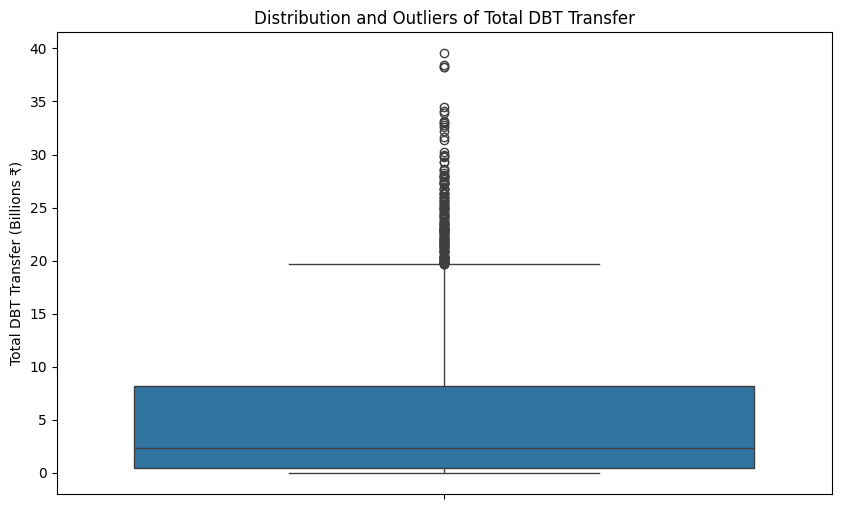

In [14]:
# 1.1 Boxplot Analysis of Total DBT Transfer

plt.figure(figsize=(10, 6))
sns.boxplot(y=df['total_dbt_transfer']/1e9)
plt.title('Distribution and Outliers of Total DBT Transfer', fontsize=12)
plt.ylabel('Total DBT Transfer (Billions ₹)')
plt.show()

# Print outlier statistics for ML consideration
Q1 = df['total_dbt_transfer'].quantile(0.25)
Q3 = df['total_dbt_transfer'].quantile(0.75)
IQR = Q3 - Q1
outlier_count = len(df[(df['total_dbt_transfer'] < (Q1 - 1.5 * IQR)) | 
                      (df['total_dbt_transfer'] > (Q3 + 1.5 * IQR))])



### 1.2 Top 10 Districts by Total DBT Transfer

This plot ranks districts by their cumulative DBT transfer amount and displays the top 10, scaled to billions for readability.

**Purpose:**  
- Identify the highest-funded districts, which are likely influential in the overall distribution.  
- Highlight regional concentration and prioritize locations for deeper analysis or modeling focus.

**Method:**  
- Aggregate `total_dbt_transfer` by `district_name`.  
- Sort and select the top 10 districts.  
- Visualize using a bar plot to compare their relative funding amounts.


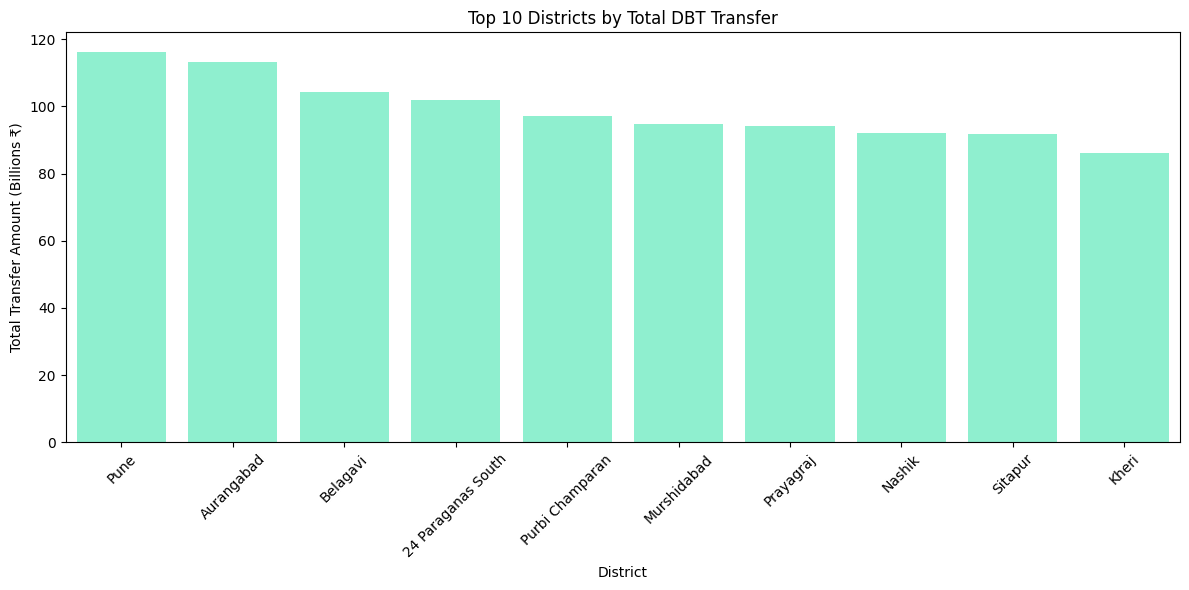

In [15]:
# 1.2 Top 10 Districts Analysis

plt.figure(figsize=(12, 6))
top_10_districts = df.groupby('district_name')['total_dbt_transfer'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_10_districts.index, y=top_10_districts.values/1e9 , color='aquamarine')
plt.title('Top 10 Districts by Total DBT Transfer', fontsize=12)
plt.xlabel('District')
plt.ylabel('Total Transfer Amount (Billions ₹)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2. Bivariate Analysis

Bivariate analysis examines the relationship between **two variables** to uncover patterns and dependencies that are valuable for feature selection and predictive modeling.  
This step helps determine which features are most strongly associated with the target variable and whether their relationships are linear or complex.

### Plots in This Section

1. **DBT Transactions vs Total Transfer (Scatter Plot with Regression)**  
   - Visualizes the relationship between the number of DBT transactions and the total transfer amount.  
   - A regression line and correlation coefficient quantify the strength and direction of the linear relationship.  
   - Useful for assessing if transaction count can serve as a strong predictor of transfer amount in future ML models.

2. **Correlation Heatmap of Numerical Features**  
   - Shows pairwise Pearson correlation among all numeric columns, including the target variable.  
   - Helps identify the most relevant predictors for modeling and detect multicollinearity issues.  
   - Guides feature selection and highlights which variables have the strongest influence on `total_dbt_transfer`.


### 2.1 DBT Transactions vs Total Transfer Amount (Scatterplot with Regression)

This plot shows how the number of DBT transactions relates to the total amount transferred, with a fitted regression line to highlight the trend.  
A correlation coefficient is displayed to quantify the strength and direction of the linear relationship.

**Purpose:**  
- Assess whether transaction count is a good predictor of transfer amount.  
- Identify linear patterns, clusters, or deviations that could influence model design.  
- Help decide if a simple linear model might capture a significant portion of variance or if more complex features are needed.


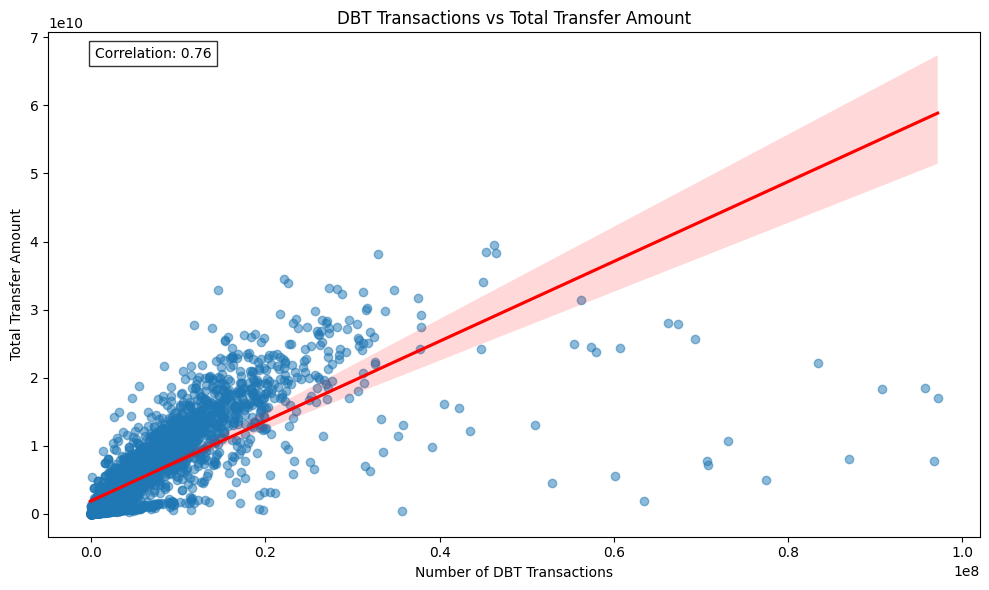

In [16]:
# 2.1 Scatter Plot with Regression Line
plt.figure(figsize=(10, 6))
sns.regplot(x='no_of_dbt_transactions', y='total_dbt_transfer', data=df, 
           scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('DBT Transactions vs Total Transfer Amount', fontsize=12)
plt.xlabel('Number of DBT Transactions')
plt.ylabel('Total Transfer Amount')

# Calculate correlation coefficient
correlation = df['no_of_dbt_transactions'].corr(df['total_dbt_transfer'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', 
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


### 2.2 Correlation Heatmap

This heatmap displays pairwise Pearson correlation coefficients among key numerical features, including the target (`total_dbt_transfer`), predictor (`no_of_dbt_transactions`), derived efficiency metric, and temporal components (`start_year`, `end_year`).

**Purpose:**  
- Quantify linear relationships to guide feature selection.  
- Detect multicollinearity (e.g., highly correlated predictors) that could affect model stability.  
- Identify which variables have the strongest association with the target to prioritize in modeling.


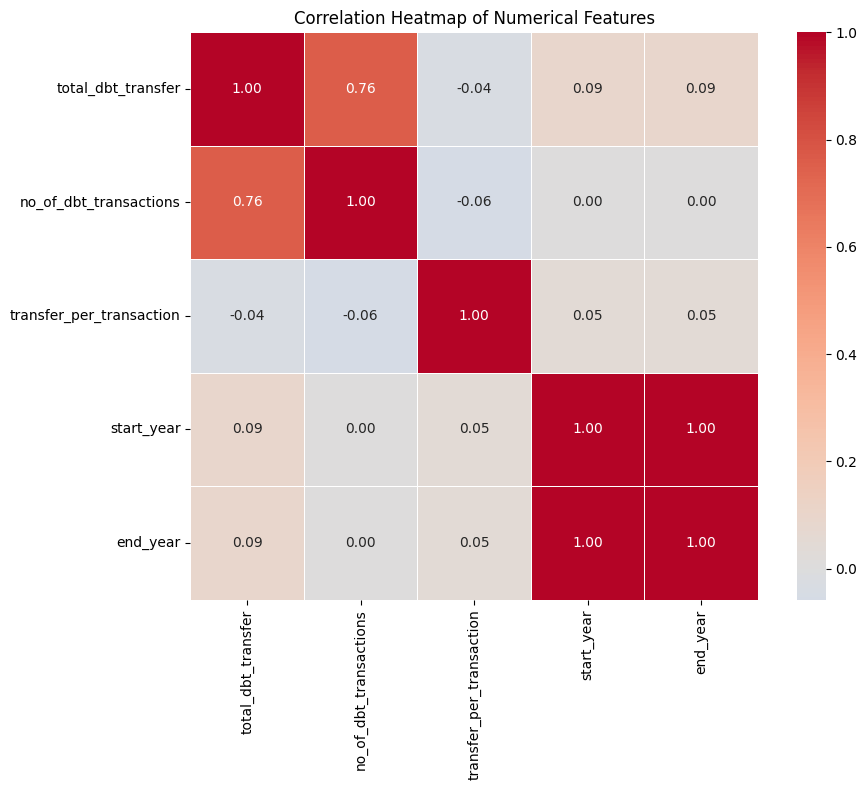

In [17]:
# 2.2 Correlation Heatmap
# Select numerical columns for correlation analysis
numeric_cols = ['total_dbt_transfer', 'no_of_dbt_transactions', 'transfer_per_transaction', 
                'start_year', 'end_year']
correlation_matrix = df[numeric_cols].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features', fontsize=12)
plt.tight_layout()
plt.show()

## 3. Multivariate Analysis

Multivariate analysis explores the interaction between **three or more variables** to uncover complex patterns and dependencies that are crucial for predictive modeling.  
This stage helps detect combined effects of multiple factors, identify clusters, and guide feature engineering for future ML models.

### Plots in This Section

1. **Time Series Analysis by State (Line Plots)**  
   - Tracks `total_dbt_transfer` and `no_of_dbt_transactions` across years for the top-performing states.  
   - Highlights state-specific trends, growth rates, and annual transaction volumes.  
   - Useful for creating **temporal features** and understanding how allocations evolve over time.

2. **Pairplot of Key Numerical Features**  
   - Visualizes pairwise relationships between multiple numeric variables simultaneously.  
   - Reveals potential **non-linear interactions, clusters, and correlations** that are critical for model input selection.  
   - Serves as a diagnostic tool for **multicollinearity** and hidden feature dependencies.

These multivariate insights provide a comprehensive view of the data, informing which variables and combinations are likely to be most predictive for **future DBT allocation modeling**.


### 3.1 Time Series Analysis by State

This section examines how both **total DBT transfer** and **number of transactions** evolve over time at the state level, focusing on the top-performing states. Temporal dynamics across multiple variables are crucial for forecasting and capturing region-specific trends.

**Purpose:**  
- Identify state-wise temporal patterns in DBT allocation and usage.  
- Compare growth trajectories and transaction volumes for the most impactful states.  
- Extract features like growth rate and average annual activity for downstream predictive modeling.

**Methods used:**  
- Aggregate `total_dbt_transfer` and `no_of_dbt_transactions` by `state_name` and `start_year`.  
- Plot time series for the top states to visualize trends in both transfer amount and transaction count.  
- Compute growth rates and average annual transactions as quantitative summaries for each state.

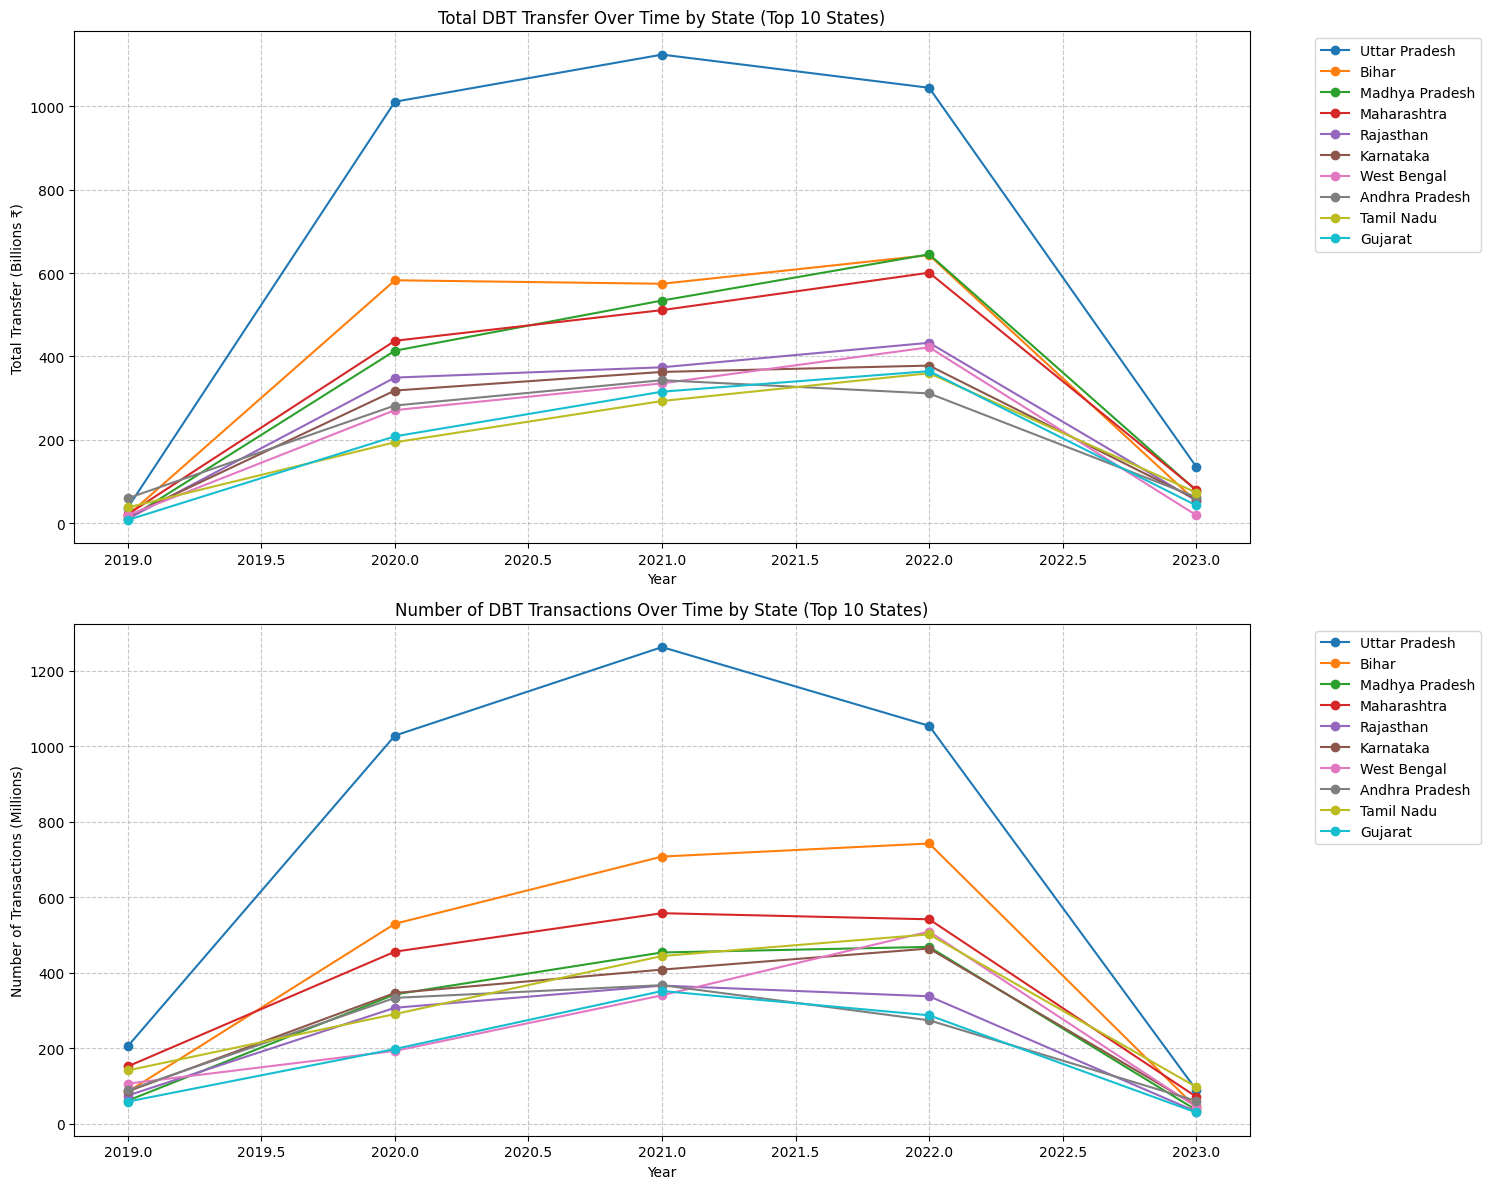

In [18]:
# 3.1 Time Series Analysis by State

# Calculate state-wise metrics per year
state_time_series = df.groupby(['state_name', 'start_year']).agg({
    'total_dbt_transfer': 'sum',
    'no_of_dbt_transactions': 'sum'
}).reset_index()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot total transfers over time for top 5 states
top_5_states = state_time_series.groupby('state_name')['total_dbt_transfer'].sum().nlargest(10).index

for state in top_5_states:
    state_data = state_time_series[state_time_series['state_name'] == state]
    ax1.plot(state_data['start_year'], state_data['total_dbt_transfer']/1e9, 
             marker='o', label=state)

ax1.set_title('Total DBT Transfer Over Time by State (Top 10 States)', fontsize=12)
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Transfer (Billions ₹)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot number of transactions over time for the same states
for state in top_5_states:
    state_data = state_time_series[state_time_series['state_name'] == state]
    ax2.plot(state_data['start_year'], state_data['no_of_dbt_transactions']/1e6, 
             marker='o', label=state)

ax2.set_title('Number of DBT Transactions Over Time by State (Top 10 States)', fontsize=12)
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of Transactions (Millions)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



### 3.2 Pairplot Analysis

**Purpose:**  
Explore multivariate relationships among key numerical features simultaneously to uncover patterns, dependencies, and potential interactions that may not be evident in isolated bivariate plots.

**What is shown:**  
- Pairwise scatter plots with density estimates on diagonals for `total_dbt_transfer`, `no_of_dbt_transactions`, `transfer_per_transaction`, and `start_year`.  
- Helps spot nonlinear relationships, clusters, and collinearity that can inform feature engineering and model selection.


<Figure size 1200x1200 with 0 Axes>

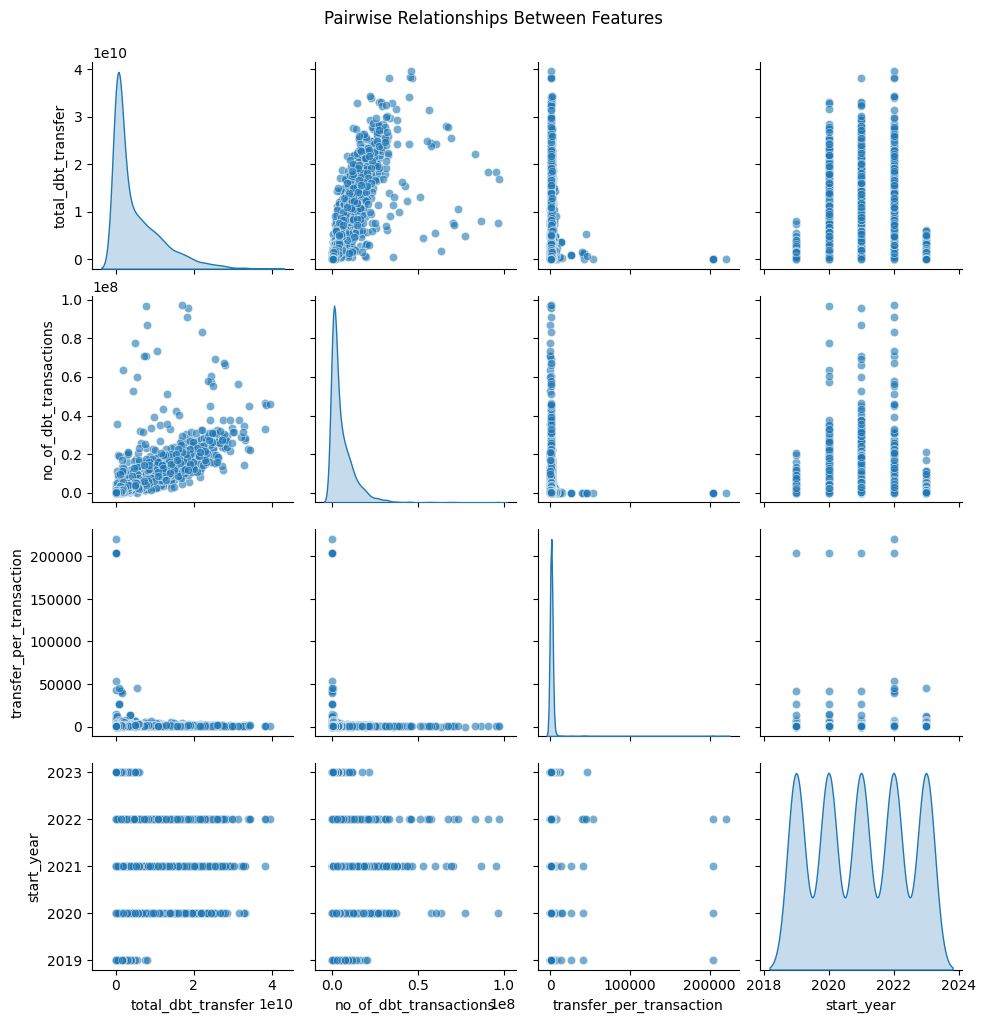

In [19]:
# 3.2 Pairplot Analysis

# Select relevant numerical features for pairplot
features_for_pairplot = ['total_dbt_transfer', 'no_of_dbt_transactions', 
                        'transfer_per_transaction', 'start_year']

# Create pairplot
plt.figure(figsize=(12, 12))
sns.pairplot(df[features_for_pairplot], diag_kind='kde', plot_kws={'alpha': 0.6})
plt.suptitle('Pairwise Relationships Between Features', y=1.02, fontsize=12)
plt.show()

## 4. Geo-Spatial Analysis

Geo-spatial analysis adds a **location-based perspective** to the EDA, revealing how DBT allocations vary across the country.  
By visualizing **spatial distribution and regional patterns**, we can identify clusters, disparities, and geographic trends that are critical for decision-making and predictive modeling.

### Objectives of Geo-Spatial Analysis
- Identify **states and districts with the highest and lowest DBT allocations**.
- Detect **regional disparities and allocation clusters**.
- Provide **features for ML models** based on location and spatial distribution.

### Plots in This Section

1. **State-wise DBT Transfer Choropleth Map**  
   - Highlights total DBT transfers across Indian states using color intensity.  
   - Useful for spotting spatial disparities and high-allocation regions.  
   - Hover tooltips display total transfer (billions ₹) and transaction counts.

2. **Regional Analysis with Aggregated Bar Plots**  
   - Aggregates states/districts into broad regions (North, South, East, West, Central).  
   - Shows regional totals, average transfer per district, and transfer efficiency (per transaction).  
   - Useful for identifying region-level patterns that can enhance predictive models.

### 4.1 State-wise DBT Transfer Distribution (Choropleth Map)

This visualization presents a **state-level choropleth map of India** showing the **total DBT transfer amount (in billions ₹)** for each state.

**Purpose:**  
- Provide a **geographical perspective** of DBT allocation across states.  
- Highlight **spatial disparities** in fund distribution, revealing regions that receive high or low transfers.  
- Support **geo-spatial feature engineering** for ML models, where geographic location can influence predictions.

**Methods Used:**  
- Aggregated `total_dbt_transfer` and `no_of_dbt_transactions` at the **state level**.  
- Converted transfer amounts to billions for readability.  
- Used **Plotly Choropleth** with an India states GeoJSON to color states based on their transfer amounts.  
- Hover tooltips show **total transfers and transaction counts** to give an immediate understanding of regional allocation intensity.

In [ ]:
# 4.1 Create State-wise Total DBT Transfer Visualization with India Map
# Download GeoJSON for Indian states
# This URL contains the GeoJSON data for Indian states
url = "https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson"
response = requests.get(url)
india_states_geo = json.loads(response.content)

# Calculate state-wise total transfers
state_metrics = df.groupby('state_name').agg({
    'total_dbt_transfer': 'sum',
    'no_of_dbt_transactions': 'sum'
}).reset_index()

# Convert transfer amounts to billions for better visualization
state_metrics['total_dbt_transfer_billions'] = state_metrics['total_dbt_transfer'] / 1e9

# Create choropleth map
fig = px.choropleth(
    state_metrics,
    geojson=india_states_geo,
    locations='state_name',
    featureidkey='properties.ST_NM',
    color='total_dbt_transfer_billions',
    color_continuous_scale='Viridis',
    range_color=(0, state_metrics['total_dbt_transfer_billions'].max()),
    hover_data={
        'total_dbt_transfer_billions': ':.2f',
        'no_of_dbt_transactions': ':,.0f'
    },
    labels={
        'total_dbt_transfer_billions': 'Total DBT Transfer (Billions ₹)',
        'no_of_dbt_transactions': 'Number of Transactions',
        'state_name': 'State'
    },
    title='State-wise DBT Transfer Distribution in India'
)

# Update the map layout
fig.update_geos(
    visible=False,
    projection_type="mercator",
    center=dict(lat=23.5937, lon=78.9629),
    lataxis_range=[6, 38],
    lonaxis_range=[68, 98]
)

fig.update_layout(
    title_x=0.5,
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='equirectangular'
    ),
    width=1000,
    height=800,
    margin={"r":0, "t":30, "l":0, "b":0}
)

fig.show()

### 4.2 Regional Analysis

This section aggregates DBT metrics into broad geographic regions (North, South, East, West, Central) based on latitude and longitude to compare regional behavior.

**Purpose:**  
- Understand how DBT allocation and transaction activity vary across coarse regions.  
- Surface regional differences in total transfers, average transfer per district, and efficiency (transfer per transaction).  
- Provide aggregated features that can support region-aware modeling or hierarchical forecasting.

**Key computations and visuals:**  
1. Regional sums of total transfer and transaction counts.  
2. Average transfer per district to normalize for region size.  
3. Number of districts in each region to contextualize volume.  
4. Transfer per transaction as an efficiency metric.  
5. Bar plots for each of these aggregated metrics to facilitate side-by-side regional comparison.


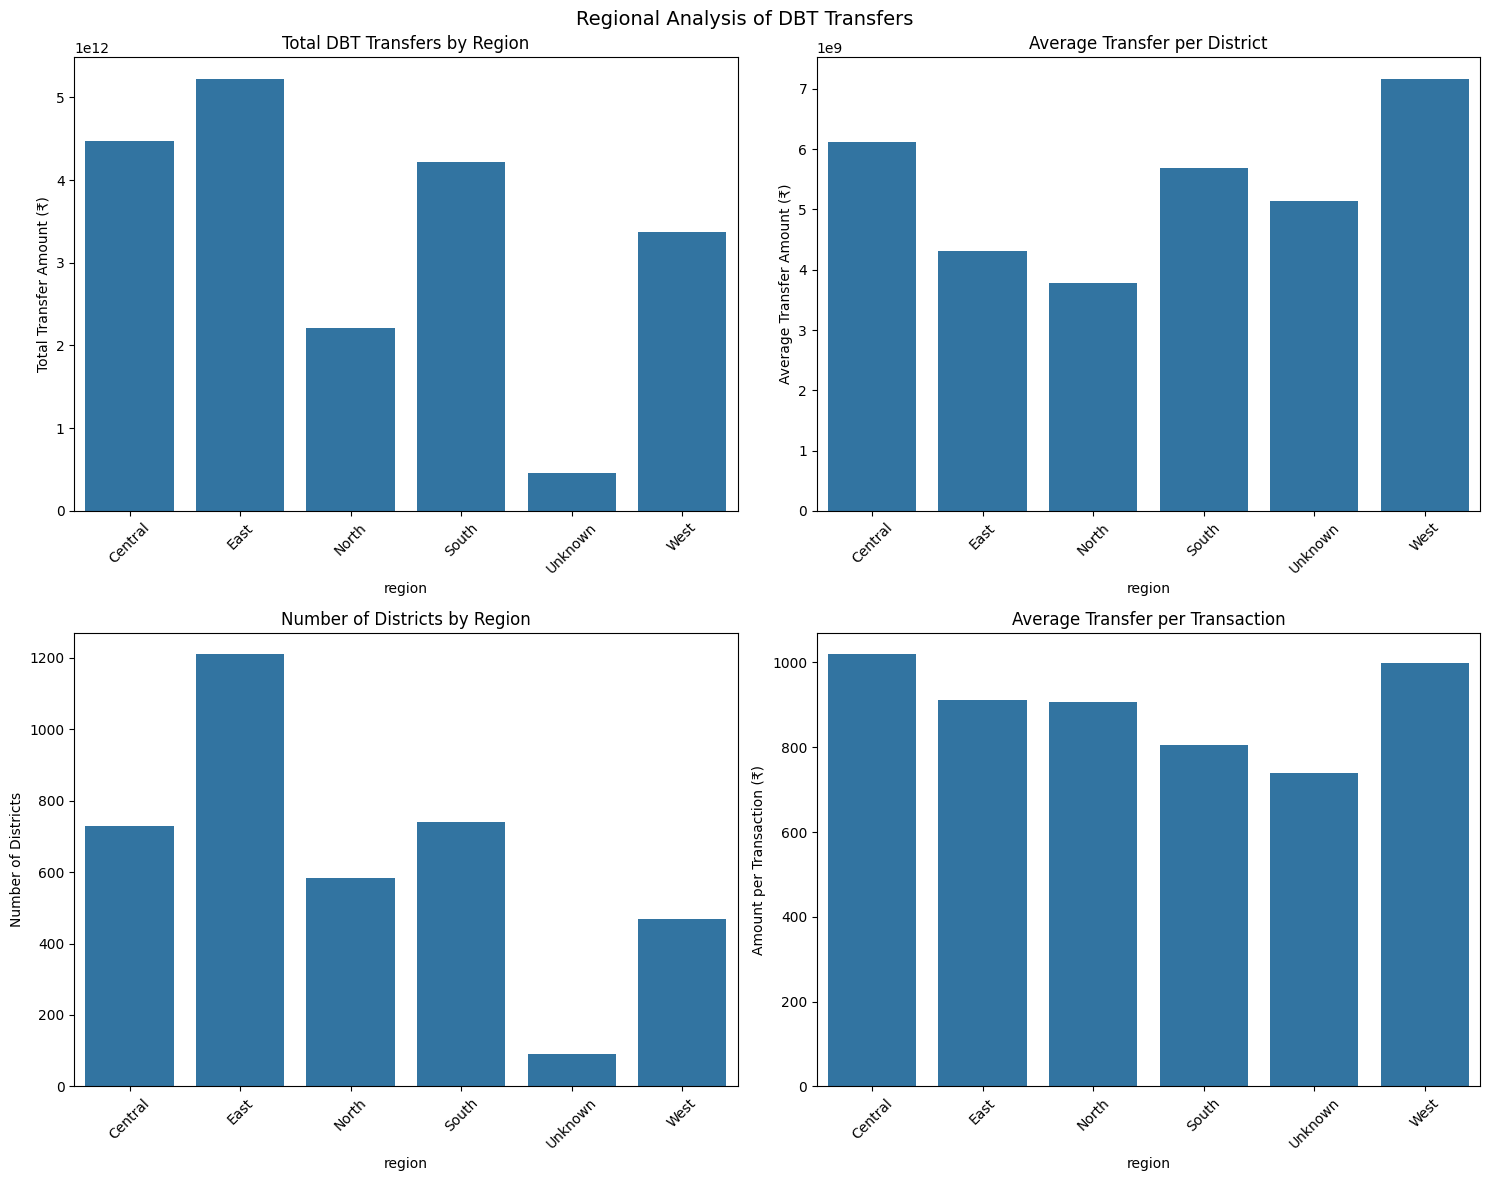

In [25]:
# 4.2 Regional Analysis

# Define regions based on latitude and longitude
def assign_region(row):
    lat, lon = row['latitude'], row['longitude']
    if pd.isna(lat) or pd.isna(lon):
        return 'Unknown'
    # Basic regional division of India
    if lat >= 28:
        return 'North'
    elif lat <= 18:
        return 'South'
    elif lon >= 83:
        return 'East'
    elif lon <= 77:
        return 'West'
    else:
        return 'Central'

# Add region information
district_metrics['region'] = district_metrics.apply(assign_region, axis=1)

# Regional summary
regional_summary = district_metrics.groupby('region').agg({
    'total_dbt_transfer': 'sum',
    'no_of_dbt_transactions': 'sum',
    'district_name': 'count'
}).rename(columns={'district_name': 'number_of_districts'})

regional_summary['avg_transfer_per_district'] = regional_summary['total_dbt_transfer'] / regional_summary['number_of_districts']
regional_summary['transfer_per_transaction'] = regional_summary['total_dbt_transfer'] / regional_summary['no_of_dbt_transactions']

# Create subplots for regional analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Regional Analysis of DBT Transfers', fontsize=14)

# 1. Total transfers by region
sns.barplot(data=regional_summary.reset_index(), 
           x='region', y='total_dbt_transfer', 
           ax=axes[0,0])
axes[0,0].set_title('Total DBT Transfers by Region')
axes[0,0].set_ylabel('Total Transfer Amount (₹)')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Average transfer per district
sns.barplot(data=regional_summary.reset_index(), 
           x='region', y='avg_transfer_per_district', 
           ax=axes[0,1])
axes[0,1].set_title('Average Transfer per District')
axes[0,1].set_ylabel('Average Transfer Amount (₹)')
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Number of districts
sns.barplot(data=regional_summary.reset_index(), 
           x='region', y='number_of_districts', 
           ax=axes[1,0])
axes[1,0].set_title('Number of Districts by Region')
axes[1,0].set_ylabel('Number of Districts')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Transfer per transaction
sns.barplot(data=regional_summary.reset_index(), 
           x='region', y='transfer_per_transaction', 
           ax=axes[1,1])
axes[1,1].set_title('Average Transfer per Transaction')
axes[1,1].set_ylabel('Amount per Transaction (₹)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
